In [63]:
# для обработки данных
import numpy as np
import pandas as pd

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# для построения моделей
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold, GridSearchCV

# метрики
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# **1. Предварительная обработка данных**


---


Раздел включает в себя:
* обзор данных;
* определение типов признаков (зависимой переменной и независимых переменных);
* удаление заведомо незначимых переменных;
* обработку пропусков и переменных относительно их типа.


## Обзор данных

In [2]:
adult = pd.read_csv('adult.csv')
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# размерность данных
adult.shape

(32561, 15)

In [4]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Переименуем переменные fnlwgt, education-num, marital-status, capital-gain, capital-loss, hours-per-week, native-country
adult.rename(columns = {'fnlwgt': 'final_weight'}, inplace=True)
adult.rename(columns = {'education-num': 'education_num'}, inplace=True)
adult.rename(columns = {'marital-status': 'marital_status'}, inplace=True)
adult.rename(columns = {'capital-gain': 'capital_gain'}, inplace=True)
adult.rename(columns = {'capital-loss': 'capital_loss'}, inplace=True)
adult.rename(columns = {'hours-per-week': 'hours_per_week'}, inplace=True)
adult.rename(columns = {'native-country': 'native_country'}, inplace=True)

**Вывод по краткому обзору данных:** 
1. Наш датафрейм имеет $32\ 561$ строк и $15$ колонок (переменных). 
2. Большинство названий переменных соответствуют их смыслу кроме переменной `fnlwgt`, поэтому было принято решение переименовать её в `final_weight`. Кроме того, все переменные, которые имеют в названии дефис (`-`), были преобразованы по стилю `snake_case`.  
3. Большинство переменных — категориальные.
4. Обнаружено $9$ категориальных переменных: `workclass`, `education`, `marital_status`, `occupation`, `relationship`, `race`, `sex`, `native_country`, `income`.

## Анализ переменных

In [6]:
adult.describe()

,age,final_weight,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
# число количественных переменных не включая целевую
adult.describe().shape[1]

6

In [8]:
# названия количественных переменных не включая целевую
adult.describe().columns

Index(['age', 'final_weight', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')

Рассмотрим число уникальных значений признаков и выведем уникальные значения категориальных переменных:

In [9]:
# все переменные
adult_vars = adult.columns[:-1]
adult_vars

Index(['age', 'workclass', 'final_weight', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')

In [10]:
for i in range(len(adult_vars)):
  print(f"Число уникальных значений в признаке {str(adult_vars[i]).ljust(20)} - "
    f"{str(adult[adult_vars[i]].nunique()).rjust(5)}")

Число уникальных значений в признаке age                  -    73
Число уникальных значений в признаке workclass            -     9
Число уникальных значений в признаке final_weight         - 21648
Число уникальных значений в признаке education            -    16
Число уникальных значений в признаке education_num        -    16
Число уникальных значений в признаке marital_status       -     7
Число уникальных значений в признаке occupation           -    15
Число уникальных значений в признаке relationship         -     6
Число уникальных значений в признаке race                 -     5
Число уникальных значений в признаке sex                  -     2
Число уникальных значений в признаке capital_gain         -   119
Число уникальных значений в признаке capital_loss         -    92
Число уникальных значений в признаке hours_per_week       -    94
Число уникальных значений в признаке native_country       -    42


In [11]:
def uniques(adult, columns):
    categorical_uniques = {}
    for column in  columns:
        categorical_uniques[column] = list(adult[column].unique())
    return categorical_uniques
    
categorical_features = ['workclass', 'education', 'marital_status' , 
                        'relationship' , 'race' ,'sex' ,'native_country' , 
                        'occupation', 'income']

uniques_dict = uniques(adult, categorical_features)

for key, value in uniques_dict.items():
    print(key, value)

workclass [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked']
education [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th']
marital_status [' Never-married', ' Married-civ-spouse', ' Divorced', ' Married-spouse-absent', ' Separated', ' Married-AF-spouse', ' Widowed']
relationship [' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried', ' Other-relative']
race [' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other']
sex [' Male', ' Female']
native_country [' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico', ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland', ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',

**Вывод по анализу переменных:** 
1. Следует отметить категориальные переменные, которые необходимо будет преобразовать в зависимости от содержания модели: `workclass`, `education`, `marital_status`, `occupation`, `relationship`, `race`, `sex`, `native_country`, `income`;
2. Отметим переменные, которые в своих значениях имеют `?`: `workclass`, `native_country`, `occupation`. В дальнейшем их необходимо обработать как пропуски.


## Обработка пропусков и категориальных переменных

In [12]:
# проверим датасет на наличие пропусков
adult.isnull().sum()

age               0
workclass         0
final_weight      0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

Таким образом, на первый взгляд, пропущенных значений нет. Однако мы помним о знаках вопроса в категориальных переменных.

In [13]:
adult.head()

,age,workclass,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
print(adult[adult['workclass'] == ' ?'].shape)
print(adult[adult['occupation'] == ' ?'].shape)
print(adult[adult['native_country'] == ' ?'].shape)

(1836, 15)
(1843, 15)
(583, 15)


In [15]:
adult = adult[adult['occupation'] != ' ?']
print(adult[adult['workclass'] == ' ?'].shape)
print(adult[adult['native_country'] == ' ?'].shape)

(0, 15)
(556, 15)


**Вывод по обработке пропусков и категориальных переменных:**
1. В датасете отсутствовали пропущенные значения как `NaN`, но присутствовали пропуски в виде строк `?`;
2. Наблюдения переменной `native_country` относительно пропусков не были удалены, так как эта переменная в целом по своей значимости вызывает для нас вопросы, поэтому ее рассмотрим позже; 
2. Все переменные готовы для дальнейшей обработке: создание новых переменных, удаление незначимых, также обработка на выбросы.

# **2. Разведочный анализ данных**


---

Раздел включает в себя:
* определение выбросов и их обработка;
* создание новых переменных и удаление незначимых;
* одномерный анализ;
* многомерный анализ.

## Определение выбросов и их обработка

In [16]:
# переменные, которые мы проверим на выбросы
adult_vars

Index(['age', 'workclass', 'final_weight', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')

Выбросы в наборах данных влияют на качество выводов. По этой причине перед началом анализа выявим выбросы в наших данных, для чего построим визуализацию.

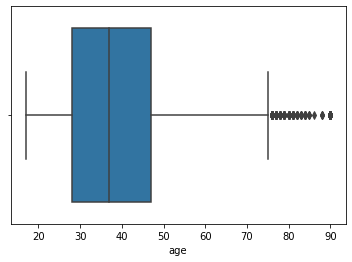

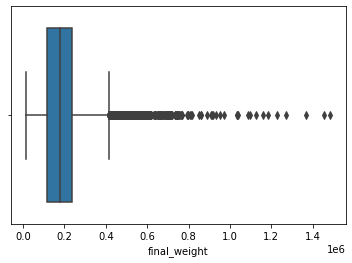

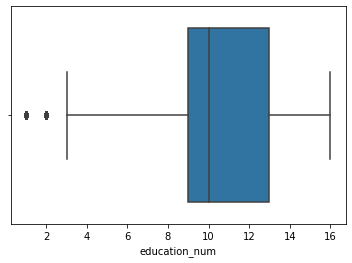

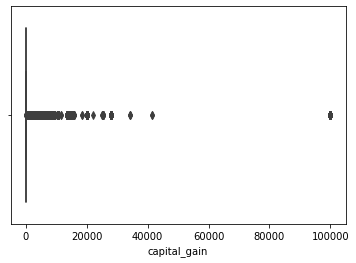

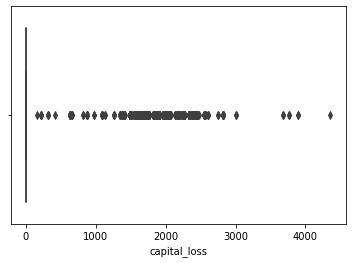

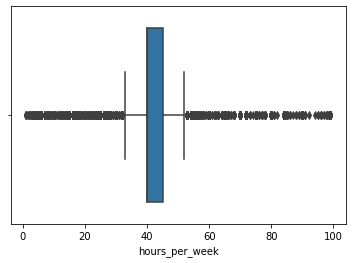

In [17]:
int_columns = ['age','final_weight', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
for i in int_columns:
    sns.boxplot(x = adult[i])
    plt.show()

**Выбросы в переменных:**
* `age`: поскольку значения в данной переменной соответствуют возможным значениям для возраста человека, то мы не будем считать наблюдения в этой переменной выбросами;
* `final_weight`: было принято решение установить квантили для данной переменной, чтобы избавиться от некоторых выбросов;
* `education_num`: поскольку минимальная продолжительность образования человека обычно составляет $4$ года, было принято решение удалить все значения, меньшие $4$;
* `capital_gain`, `capital_loss` и `hoursperweek`: в данных переменных было принято решение удалить выбросы по фильтрам, которые были выбраны согласно графикам выше.

In [18]:
# Установим квантиль чтобы избавиться от некоторых выбросов
adult = adult[(adult['final_weight'] < adult['final_weight'].quantile(0.99)) & (adult['final_weight'] > adult['final_weight'].quantile(0.01))]

# Удалить значения в строках, в которых продолжительность образования ниже 4
adult = adult[adult['education_num'] >= 4]

# Удалить значения в строках, в которых capital_gain выше 60 000
adult = adult[adult['capital_gain'] <= 60_000]

# Удалить значения в строках, в которых capital_loss ниже 3 000
adult = adult[adult['capital_loss'] <= 3_000]

# Удалить значения в строках, в которых hoursperweek ниже 20 и выше 80
adult = adult[(adult['hours_per_week'] <= 80) | (adult['hours_per_week'] >= 20)]

adult.shape

(29446, 15)

Проверим результат удаления выбросов:

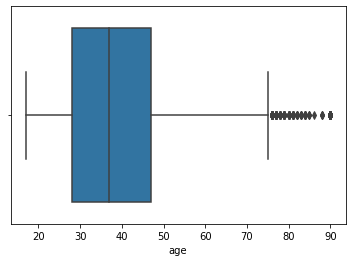

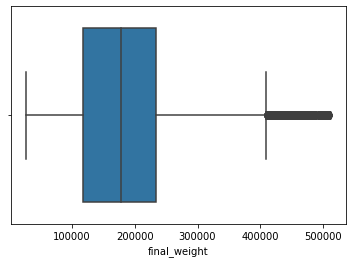

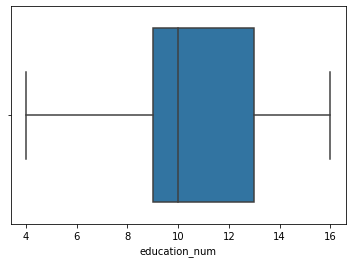

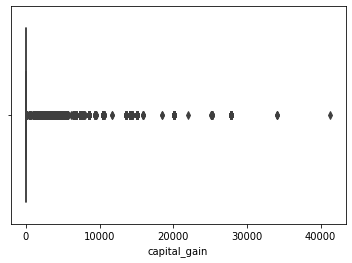

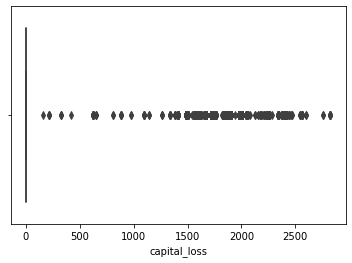

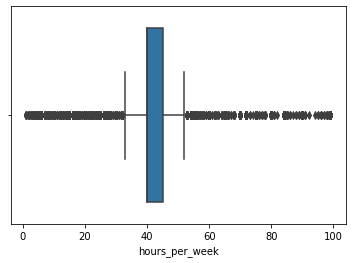

In [19]:
int_columns = ['age', 'final_weight', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
for i in int_columns:
    sns.boxplot(x = adult[i])
    plt.show()

## Укрупнение переменных

Произведем укрупнение следующих переменных: `education` и `marital_status`.
Переменную `education` было принято решение укрупнить согласно российской системе образования, а в переменной 'marital_status' мы укрупним семейное положение лишь до $3$: "Замужем", "Не замужем" и "Никогда не была замужем".

In [20]:
adult['education'] = adult['education'].replace({
                            'HS-grad': 'school_graduate', 
                            '11th': 'school_undergraduate', 
                            '9th': 'school_undergraduate', 
                            '7th-8th': 'school_undergraduate',
                            'Assoc-acdm': 'school_undergraduate',
                            'Some-college': 'school_graduate',
                            'Assoc-voc': 'school_undergraduate',
                            'Prof-school': 'school_graduate',
                            '5th-6th': 'school_undergraduate',
                            '10th': 'school_undergraduate',
                            '1st-4th': 'school_undergraduate',
                            'Preschool': 'school_undergraduate',
                            '12th': 'school_graduate'}, regex=True)
adult['education'].unique()

array([' Bachelors', ' school_graduate', ' school_undergraduate',
       ' Masters', ' Doctorate'], dtype=object)

In [21]:
adult['marital_status'] = adult['marital_status'].replace({
                            'Married-civ-spouse': 'married', 
                            'Married-spouse-absent': 'married', 
                            'Separated': 'married', 
                            'Married-AF-spouse': 'married',
                            'Widowed': 'divorced',
                            'Never-married':'never_married'
                            }, regex=True)
adult['marital_status'].unique()

array([' never_married', ' married', ' Divorced', ' divorced'],
      dtype=object)

Проверим состав других переменных в процентном соотношении:

In [22]:
adult['workclass'].value_counts(normalize=True) * 100

 Private             73.802893
 Self-emp-not-inc     8.279563
 Local-gov            6.897371
 State-gov            4.248455
 Self-emp-inc         3.596414
 Federal-gov          3.131155
 Without-pay          0.044149
Name: workclass, dtype: float64

In [23]:
adult['relationship'].value_counts(normalize=True) * 100

 Husband           41.265367
 Not-in-family     25.602798
 Own-child         14.996944
 Unmarried         10.599063
 Wife               4.679753
 Other-relative     2.856076
Name: relationship, dtype: float64

In [24]:
adult['occupation'].value_counts(normalize=True) * 100

 Prof-specialty       13.580792
 Exec-managerial      13.373633
 Craft-repair         13.349861
 Adm-clerical         12.449908
 Sales                12.072947
 Other-service        10.541330
 Machine-op-inspct     6.408341
 Transport-moving      5.161991
 Handlers-cleaners     4.333356
 Farming-fishing       3.076819
 Tech-support          3.070026
 Protective-serv       2.149698
 Priv-house-serv       0.400734
 Armed-Forces          0.030564
Name: occupation, dtype: float64

In [25]:
adult['race'].value_counts(normalize=True) * 100

 White                 85.875841
 Black                  9.410446
 Asian-Pac-Islander     3.141343
 Amer-Indian-Eskimo     0.818447
 Other                  0.753922
Name: race, dtype: float64

Таким образом, в переменной `race` более $85\%$ значений относятся к одной категории, поэтому было принято решение укрупнить данный параметр до `White` и `Other_races`.

In [26]:
adult['race'] = adult['race'].replace({'Black': 'Other_races',
                            'Asian-Pac-Islander': 'Other_races',
                            'Amer-Indian-Eskimo': 'Other_races',
                            'Other': 'Other_races'}, regex=True)
adult['race'].unique()

array([' White', ' Other_races'], dtype=object)

## Одномерный анализ

Во-первых, стоит взглянуть на средний возраст людей с зарплатой более $50\ 000$ по странам:

In [27]:
temp = adult[adult['income'] == '>50K']
country_vs_age = adult[['native_country', 'income', 'age']].groupby(['native_country', 'income']).mean().sort_values('age', ascending=False)
country_vs_age = country_vs_age.reset_index()

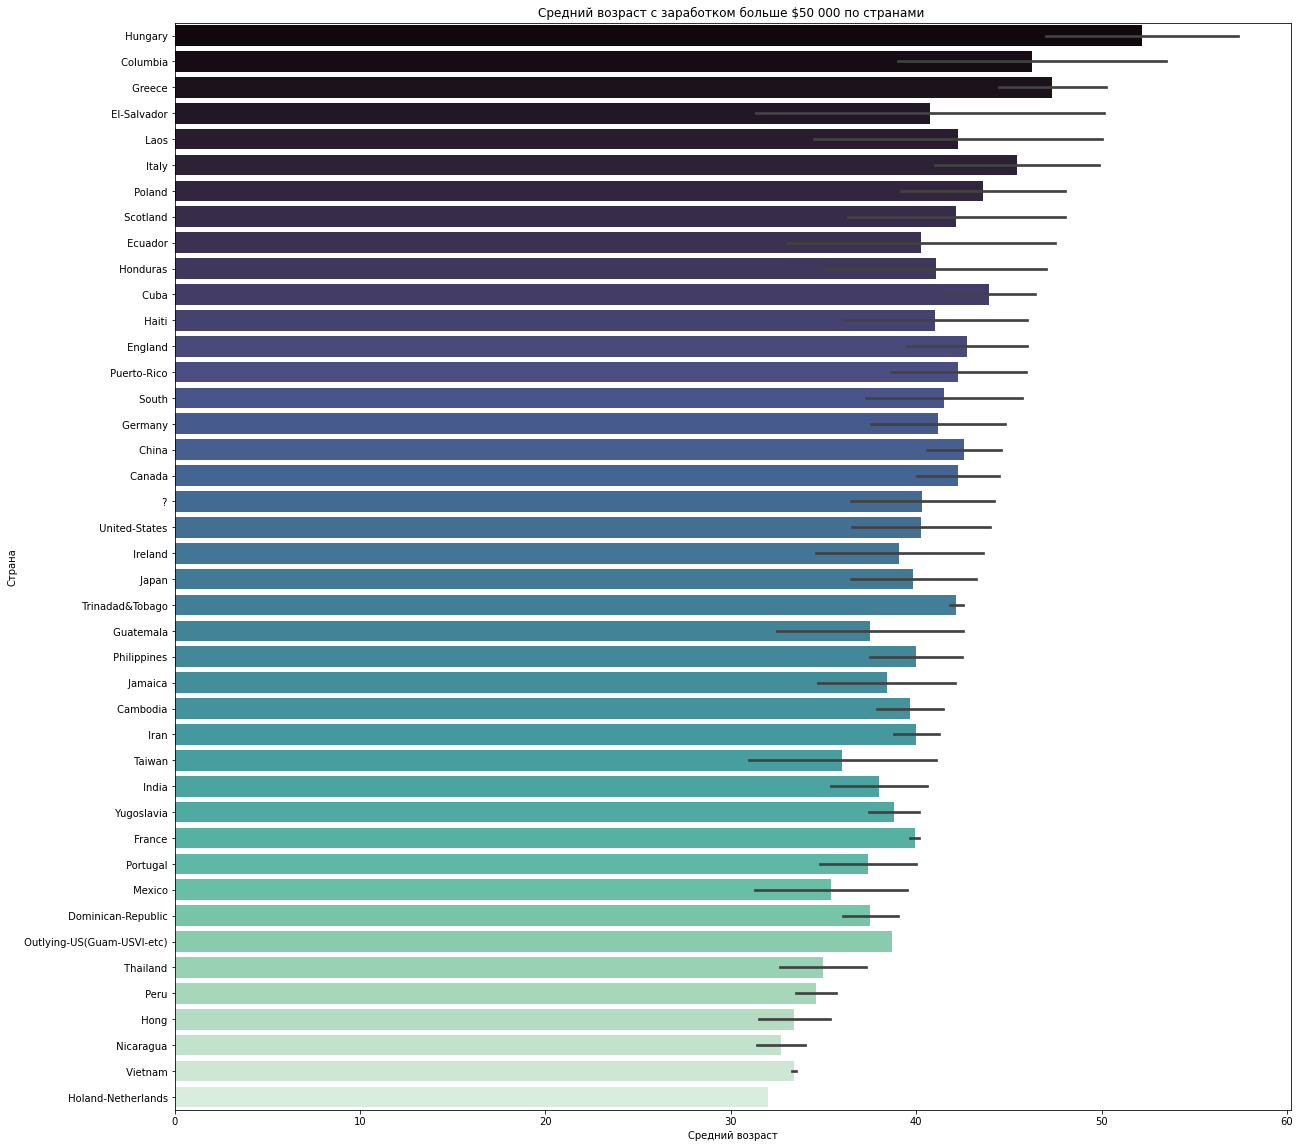

In [28]:
plt.figure(figsize = (20, 20))
sns.barplot(x='age', y='native_country', data=country_vs_age, palette='mako', orient='h')
plt.xlabel("Средний возраст")
plt.ylabel("Страна")
plt.title("Средний возраст с заработком больше $50 000 по странами ")
plt.show()

**Таким образом, можно сделать сразу несколько выводов:**
* Во-первых, в абсолютно всех странах в среднем лишь после $30$ лет люди начинают зарабатывать более $50\ 000$ долларов в год;

* Во-вторых, страной, где люди в среднем выходят на заработную плату в $50\ 000$ долларов за наименьший срок, являются Нидерланды. А страной, где люди начинают зарабатывать более $50\ 000$ долларов за наибольший срок и лишь ближе к своей старости, является Венгрия.

Во-вторых, посмотрим на разницу в доходах между мужчинами и женщинами:



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


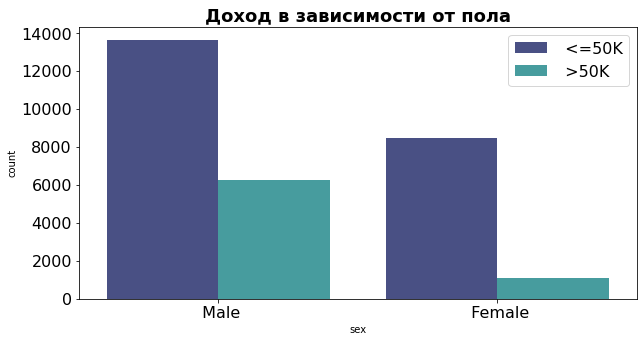

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(adult['sex'], hue=adult['income'], palette='mako')
plt.title('Доход в зависимости от пола', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

**Отсюда можно увидеть значительный разрыв в доходах между мужчинами и женщинами:**
* для женщин менее $10\%$ взрослых зарабатывают более $50\ 000$ долларов в год;
* для мужчин около $33\%$ из них зарабатывают более $50\ 000$ долларов в год.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


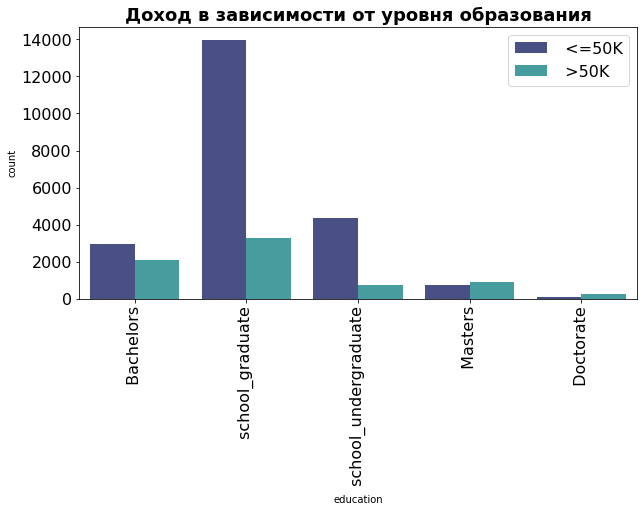

In [30]:
plt.figure(figsize=(10, 5))
sns.countplot(adult['education'], hue=adult['income'], palette='mako')
plt.title('Доход в зависимости от уровня образования', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

Таким образом, людей, окончивних только школу, больше как среди зарабатывающих более $50\ 000$ долларов в год, так и меньше. Наименьшие доходы имеют люди, имеющие степень доктора. 

Данный результат достаточно противоречив, однако мы связываем это с тем, что в целом число людей, окончивших лишь только школу, значительно превышает людей с высшим образованием - а значит и шанс иметь большую зарплату попросту выше.

## Отбор признаков

In [31]:
adult['income'].replace(to_replace=' <=50K', value=0, inplace=True)
adult['income'].replace(to_replace=' >50K', value=1, inplace=True)
adult.income.unique()

array([0, 1])

Определим переменные, в которых более $85\%$ значений относятся только к одной категории, и удалим их:

In [32]:
categorical_drop = []
for i in categorical_features:
    if (adult[i].value_counts(normalize=True)[0]) > 0.85:
        categorical_drop.append(i)
print(categorical_drop)

['race', 'native_country']


In [33]:
numerical_features = ['age', 'final_weight', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
numerical_drop = []
for i in numerical_features:
    if adult[i].value_counts(normalize=True).iloc[0] > 0.85:
        numerical_drop.append(i)
print(numerical_drop)

['capital_gain', 'capital_loss']


* В переменной `native_country` более $85\%$ значений равны одной стране;

* В переменных `capital_gain` и `capital_loss` более $85\%$ значений также равны какому-то одному числу, поэтому они не будут участвовать в моделировании;

Следовательно, мы исключаем эти $3$ переменные (`native_country`, `capital_gain`, `capital_loss`) из матрицы признаков.

In [34]:
X = adult.drop(labels = categorical_drop + numerical_drop + ['income'], axis=1)
y = adult['income']

Кроме того, нам также следует удалить переменную `final_weight`, ведь мы попросту не сможем его проинтерпретировать.

In [35]:
X.drop('final_weight', axis=1, inplace=True)

Также, переменные, связанные с образованием (`education` и `education_num`) в целом несут один и тот же смысл, поэтому было принято решение удалить переменную `education_num`:

In [36]:
X.drop('education_num', axis=1, inplace=True)

# **3. Построение моделей**


---

Раздел включает в себя:
* подготовку данных для построения моделей;
* модель классификации с помощью метода ближайших соседей;
* модель классификации с помощью случайного леса;

## Подготовка данных для построения регрессий

In [37]:
# разделим категориальные переменные которые необходимо закодировать

cols_X = pd.DataFrame(X.dtypes)
X_cat_cols = list(cols_X[cols_X[0]=='object'].index)
X_num_cols = list(cols_X[cols_X[0]=='int64'].index)
X_cat_cols

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'sex']

In [38]:
# под вопросом
X = pd.get_dummies(data=X, prefix=X_cat_cols, drop_first=True)
X.head()

,age,hours_per_week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ Doctorate,education_ Masters,...,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male
0,39,40,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,50,13,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,38,40,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,53,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,28,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [39]:
# разделим данные на тренировочный набор данных и тестовый
my_random_state = 42

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=my_random_state)

In [41]:
X_val.head()

,age,hours_per_week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ Doctorate,education_ Masters,...,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male
12088,28,20,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
20914,23,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32489,61,40,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
27440,51,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15016,62,99,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
# масштабирование числовых переменных
sc = StandardScaler()
X_train.head()

,age,hours_per_week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ Doctorate,education_ Masters,...,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male
29216,28,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5653,50,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6791,17,25,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3586,28,40,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17611,28,99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [43]:
X_train[X_num_cols] = sc.fit_transform(X_train[X_num_cols])
X_val[X_num_cols] = sc.transform(X_val[X_num_cols])
X_train.head()

,age,hours_per_week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ Doctorate,education_ Masters,...,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Male
29216,-0.791532,-0.078733,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5653,0.887194,-0.078733,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6791,-1.630894,-1.328661,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3586,-0.791532,-0.078733,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17611,-0.791532,4.837652,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


После кодирования категориальных переменных наша окончательная матрица признаков имеет $36$ столбцов. Данные признаки мы и будем использовать для обучения нашей модели в следующем разделе.

## Обучение моделей классификации

### Метод ближайших соседей

In [44]:
knn = KNeighborsClassifier(n_neighbors=35)
knn.fit(X_train,y_train)
knn_y_pred = knn.predict_proba(X_val)
knn_roc = roc_auc_score(y_val, knn_y_pred[:,-1])
print('ROC AUC score :', knn_roc)
print(knn.get_params())

ROC AUC score : 0.8742729101145152
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 35, 'p': 2, 'weights': 'uniform'}


In [45]:
d = {'neighbors': [knn_roc]}
results = pd.DataFrame(d, index=['ROC AUC Score'])
results = results.transpose()
results

,ROC AUC Score
neighbors,0.874273


In [46]:
cv = KFold(n_splits=5, shuffle=True, random_state=my_random_state)

In [48]:
cross_val_score(KNeighborsClassifier(n_neighbors=5), X_train, y_train, cv=cv)

array([0.81593842, 0.80959928, 0.81661761, 0.81276885, 0.81499094])

In [49]:
knn = KNeighborsClassifier()

gs = GridSearchCV(
    estimator=knn,
    param_grid={'n_neighbors': np.arange(6, 21, 2)}, 
    n_jobs=-1, 
    scoring='f1',
    cv=cv)

In [50]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 6,  8, 10, 12, 14, 16, 18, 20])},
             scoring='f1')

In [51]:
best_hypo = gs.best_params_
best_hypo

{'n_neighbors': 20}

In [52]:
y_pred = gs.predict(X_val)

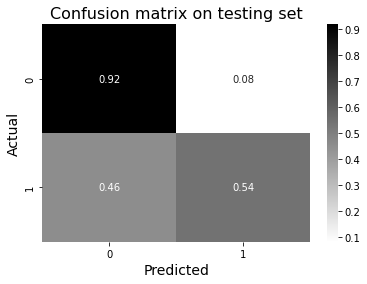

In [53]:
conf_test = confusion_matrix(y_val, y_pred, normalize='true')

sns.heatmap(conf_test, annot=True, fmt='.2f', cmap='binary')
plt.title('Confusion matrix on testing set', size=16)
plt.xlabel('Predicted', size=14)
plt.ylabel('Actual', size=14)
plt.show()

In [55]:
knn_y_pred = gs.best_estimator_.predict_proba(X_val)
knn_roc = roc_auc_score(y_val, knn_y_pred[:,-1])
print('ROC AUC score :', knn_roc)

ROC AUC score : 0.8705499431994106


**Вывод по построению моделей ближайших соседей:**
* По первой модели и по оптимальной модели значения метрик оказались удовлетворительными, но не лучшими, по нашему мнению;
* Модель хорошо предсказывает доходы меньше $50\ 000$ долларов;
* При этом наилучшую модель здесь сложно выбрать, так как значения $ROC\ AUC$ оказались очень близки, поэтому мы остановим свой выбор на второй модели.

### Случайный лес

In [56]:
rf = RandomForestClassifier(random_state=my_random_state)
rf.fit(X_train,y_train)
rf_y_pred = rf.predict_proba(X_val)
rf_roc = roc_auc_score(y_val,rf_y_pred[:,-1])
print(rf_roc)
print(rf.get_params())

0.8456657758125365
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [57]:
results.loc['forest'] = rf_roc
results

,ROC AUC Score
neighbors,0.874273
forest,0.845666


In [58]:
gs = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={'max_depth': np.arange(1, 101, 10), 'criterion': ['entropy']}, 
    n_jobs=-1, 
    scoring='f1',
    cv=cv)

In [59]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='f1')

In [60]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 21}

In [61]:
model = RandomForestClassifier(criterion='entropy', max_depth=21)
model.fit(X_train,y_train)
y_pred = model.predict_proba(X_val)
model_roc = roc_auc_score(y_val, y_pred[:,-1])
print(model_roc)

0.8734399548515372


In [67]:
model_1 = DecisionTreeClassifier(criterion='entropy', max_depth=2)
model_1.fit(X_train,y_train)
y_pred = model_1.predict_proba(X_val)
model_roc = roc_auc_score(y_val, y_pred[:,-1])
print(model_roc)

0.7745684328108549


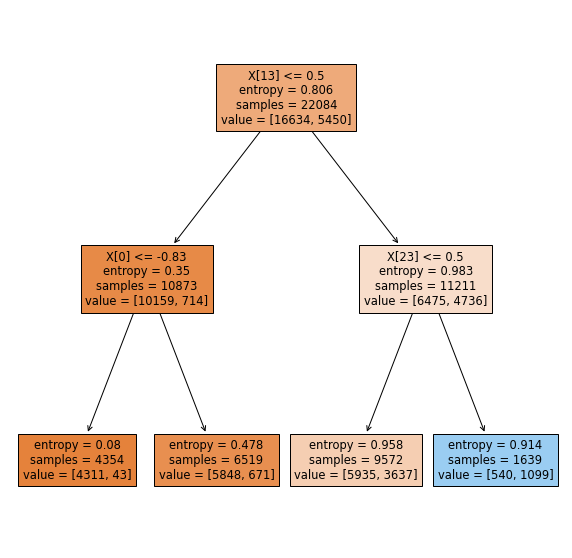

In [68]:
fig = plt.figure(figsize=(10, 10))
_ = tree.plot_tree(model_1, filled=True)

**Вывод по моделям случайного леса:**
1. По качеству оптимальная модель случайного леса близка к оптимальной модели ближайших соседей;
2. Так как значения качества близки, мы остановим свой выбор на модели случайного леса, так как она максимальна легка в интерпретации.

## Заключение

Наилучшая модель: метод ближайших соседей. Однако это очень жесткий ответ, так как оптимальная модель по случайному лесу имеет очень близкий скор к модели ближайших соседей.

Из приведенного выше списка видно, что модель случайного леса работает лучше, чем метод ближайших соседей: легкая интерпетация, степени понимания для конечного пользователя, высокое качество.

И, таким образом, наша окончательная модель, полученная с помощью `соседей или леса`, способна предсказать группу дохода по тестовым данным с показателем `ROC AUC` в $87\%$.